今天来进行多目标优化

## 1. 准备工作：数据预处理与基准模型

首先，我们运行你提供的代码。这段代码完成了以下工作：
1.  加载数据。
2.  对分类型和连续型特征进行预处理，包括标签编码、独热编码和缺失值填充。
3.  划分训练集和测试集。
4.  训练一个默认参数的随机森林模型作为我们的基准（Baseline），以便后续与优化后的模型进行对比。

In [3]:
from xgboost import XGBClassifier
import pandas as pd    
import numpy as np     
import matplotlib.pyplot as plt    
import seaborn as sns   
import warnings
warnings.filterwarnings('ignore') 
 

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

data=pd.read_csv('data.csv')

# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
maps={
    'Home Ownership' : {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
    },
    'Years in current job':{
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
},
    'Term':{
    'Short Term': 0,
    'Long Term': 1
} 
}

data=data.replace(maps)

# Purpose 独热编码，记得需要将bool类型转换为数值
data=pd.get_dummies(data,columns=['Purpose'])
data2=pd.read_csv('data.csv')
list_diff=data.columns.difference(data2.columns)
data[list_diff]=data[list_diff].astype(int)

data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的XGBoost ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数XGBoost (训练集 -> 测试集) ---")
import time # 这里介绍一个新的库，time库，主要用于时间相关的操作，因为调参需要很长时间，记录下会帮助后人知道大概的时长
start_time = time.time() # 记录开始时间
rf_model = XGBClassifier(random_state=42)
rf_model.fit(X_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(X_test) # 在测试集上预测
end_time = time.time() # 记录结束时间

print(f"训练与预测耗时: {end_time - start_time:.4f} 秒")
print("\n默认XGBoost 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认XGBoost 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数XGBoost (训练集 -> 测试集) ---
训练与预测耗时: 0.3825 秒

默认XGBoost 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1059
           1       0.62      0.37      0.46       441

    accuracy                           0.75      1500
   macro avg       0.70      0.64      0.65      1500
weighted avg       0.73      0.75      0.72      1500

默认XGBoost 在测试集上的混淆矩阵：
[[960  99]
 [280 161]]


---

## 2. 什么是多目标优化？

在很多现实问题中，我们往往需要同时优化多个目标，而这些目标常常是相互冲突的。例如：
*   在投资中，我们希望 **收益率最高**，同时 **风险最低**。
*   在制造业中，我们希望 **产品质量最好**，同时 **生产成本最低**。
*   在机器学习中，我们希望模型的 **精确率（Precision）** 和 **召回率（Recall）** 都尽可能高。

这种需要同时平衡多个冲突目标的问题，就是 **多目标优化（Multi-Objective Optimization）**。

### 帕累托最优（Pareto Optimality）

与单目标优化不同，多目标优化通常没有唯一的“最佳解”，因为提升一个目标可能会导致另一个目标变差。因此，我们引入了 **帕累托最优** 的概念。

*   **支配（Dominate）**：如果一个解 A 在所有目标上都不比解 B 差，并且至少在一个目标上比解 B 好，那么我们说“解 A 支配解 B”。
*   **帕累托最优解（Pareto Optimal Solution）**：如果一个解没有被任何其他解所支配，那么它就是一个帕累托最优解。
*   **帕累托前沿（Pareto Front）**：所有帕累托最优解构成的集合。

我们的目标就是找到这个“帕累托前沿”，它代表了在不同目标之间的最佳“权衡”方案。决策者可以根据具体需求，从这个集合中选择一个最合适的解。


---

## 3. 使用 DEAP 库实现多目标优化

**DEAP (Distributed Evolutionary Algorithms in Python)** 是一个强大的Python库，专门用于实现遗传算法、遗传编程、演化策略等演化计算方法。它非常适合解决多目标优化问题。

我们将使用 DEAP 中的 **NSGA-II (Non-dominated Sorting Genetic Algorithm II)** 算法，这是一种非常经典和高效的多目标遗传算法。

**基本步骤如下：**
1.  **安装 DEAP**：首先需要安装这个库。
2.  **定义问题**：
    *   **个体（Individual）**：定义一个解的结构。在我们的案例中，一个个体就是一组随机森林的超参数（如 `n_estimators`, `max_depth` 等）。
    *   **适应度（Fitness）**：定义我们的优化目标。在这里，是最大化精确率和召回率。
3.  **创建工具箱（Toolbox）**：
    *   **评估函数（Evaluation Function）**：这是核心部分。它接收一个个体（一组超参数），用这组参数训练一个模型，然后在测试集上评估其表现，并返回适应度（精确率和召回率）。
    *   **遗传算子（Genetic Operators）**：定义算法如何演化，包括：
        *   **选择（Selection）**：如何从当前种群中选择优秀的个体进入下一代。
        *   **交叉（Crossover）**：如何组合两个父代个体以产生新的子代。
        *   **变异（Mutation）**：如何对个体进行小幅度的随机改变，以增加种群的多样性。
4.  **运行算法**：将所有部分组合起来，运行 NSGA-II 算法进行迭代演化。
5.  **分析结果**：从最终的种群中提取帕累托前沿，并进行分析和可视化。

---

## 4. 案例实战：SGBoost的精确率和召回率

In [4]:
import random
from deap import base, creator, tools, algorithms

# 4.1 定义问题：个体与适应度

# 定义适应度：我们需要最大化两个目标，所以权重都设为 1.0
# weights=(1.0, 1.0) 表示我们希望同时最大化这两个值
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))

# 定义个体：每个个体包含一组随机森林的超参数
# 我们选择优化4个关键超参数：
# 1. n_estimators (树的数量)
# 2. max_depth (树的最大深度)
# 3. min_samples_split (节点分裂所需的最小样本数)
# 4. min_samples_leaf (叶节点所需的最小样本数)
creator.create("Individual", list, fitness=creator.FitnessMulti)

# 4.2 创建工具箱 (Toolbox)
toolbox = base.Toolbox()

# 定义每个基因（超参数）的生成方式
# n_estimators: 整数，范围 [50, 300]
toolbox.register("attr_n_estimators", random.randint, 50, 300)
# max_depth: 整数，范围 [5, 50]
toolbox.register("attr_max_depth", random.randint, 5, 50)
# min_samples_split: 整数，范围 [2, 20]
toolbox.register("attr_min_samples_split", random.randint, 2, 20)
# min_samples_leaf: 整数，范围 [1, 20]
toolbox.register("attr_min_samples_leaf", random.randint, 1, 20)

# 将基因组合成个体
# n=1 表示每个函数调用1次，生成一个完整的个体
toolbox.register("individual", tools.initCycle, creator.Individual, 
               (toolbox.attr_n_estimators, toolbox.attr_max_depth, 
                toolbox.attr_min_samples_split, toolbox.attr_min_samples_leaf), n=1)

# 定义种群
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 4.3 定义评估函数
def evaluate_rf(individual):
    """
    评估函数：接收一个个体（超参数组合），返回其在测试集上的（精确率, 召回率）
    """
    # 从个体中解析超参数
    n_estimators, max_depth, min_samples_split, min_samples_leaf = individual
    
    # 创建并训练随机森林模型
    rf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1  # 使用所有可用的CPU核心
    )
    rf.fit(X_train, y_train)
    
    # 在测试集上进行预测
    predictions = rf.predict(X_test)
    
    # 计算精确率和召回率
    # precision_score 和 recall_score 默认计算正类（标签为1）的指标
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    
    # 返回评估结果，注意必须是元组
    return (precision, recall)

# 注册评估函数、交叉、变异和选择算子
toolbox.register("evaluate", evaluate_rf)
toolbox.register("mate", tools.cxTwoPoint) # 两点交叉
toolbox.register("mutate", tools.mutUniformInt, low=[50, 5, 2, 1], up=[300, 50, 20, 20], indpb=0.2) # 均匀整数变异
toolbox.register("select", tools.selNSGA2) # NSGA-II 选择算法

现在，我们设置好遗传算法的参数并运行它。
*   `NGEN`：演化的代数。
*   `MU`：每一代种群的个体数量。
*   `CXPB`：交叉概率。
*   `MUTPB`：变异概率。

**注意**：这个过程会训练大量模型，可能需要几分钟到十几分钟的时间，具体取决于你的计算机性能。

In [5]:
def run_optimization():
    """
    运行NSGA-II多目标优化算法
    
    这个函数的作用：
    1. 设置统计信息收集器，用于监控优化过程
    2. 创建初始种群
    3. 运行遗传算法进行多目标优化
    4. 返回最终的优化结果
    """
    
    # 统计信息收集器 - 用于监控优化过程
    # 这些统计信息帮助我们了解算法的收敛情况
    stats = tools.Statistics(lambda ind: ind.fitness.values)  # 获取每个个体的适应度值
    
    # 注册统计函数 - 对每一代种群计算这些统计量
    stats.register("avg", np.mean, axis=0)  # 平均值：看整体水平趋势
    stats.register("std", np.std, axis=0)   # 标准差：看种群多样性
    stats.register("min", np.min, axis=0)   # 最小值：看最差个体表现  
    stats.register("max", np.max, axis=0)   # 最大值：看最好个体表现

    print("   开始多目标优化...")
    print("   将监控以下统计信息：")
    print("   • avg: 每一代的平均精确率和召回率")
    print("   • std: 种群的多样性程度") 
    print("   • min: 最差个体的表现")
    print("   • max: 最好个体的表现")
    print()

    # 初始化种群
    pop = toolbox.population(n=50)  # 创建50个随机个体作为初始种群
    print(f"初始化种群完成，种群大小: {len(pop)}")
    
    # 运行NSGA-II算法进行演化
    print("开始演化过程...")
    start_time = time.time()
    
    # eaMuPlusLambda 是 DEAP 提供的 (μ + λ) 演化策略
    # μ: 父代数量，λ: 子代数量
    final_pop, logbook = algorithms.eaMuPlusLambda(
        pop, toolbox, 
        mu=50,           # 父代种群大小
        lambda_=50,      # 每一代产生的子代数量  
        cxpb=0.7,        # 交叉概率 (70%的个体会进行交叉)
        mutpb=0.2,       # 变异概率 (20%的个体会发生变异)
        ngen=20,         # 演化代数 (为了演示设置得较小)
        stats=stats,     # 统计信息收集器
        halloffame=None, # 不使用名人堂
        verbose=True     # 显示每一代的进化过程
    )
    
    end_time = time.time()
    
    print(f"\n多目标优化完成！")
    print(f"总耗时: {end_time - start_time:.2f} 秒")
    print(f"最终种群大小: {len(final_pop)}")
    
    return final_pop

# 运行优化
print("=" * 60)
print("开始运行多目标优化算法")
print("=" * 60)
final_pop = run_optimization()

开始运行多目标优化算法
   开始多目标优化...
   将监控以下统计信息：
   • avg: 每一代的平均精确率和召回率
   • std: 种群的多样性程度
   • min: 最差个体的表现
   • max: 最好个体的表现

初始化种群完成，种群大小: 50
开始演化过程...
gen	nevals	avg                    	std                    	min                    	max                    
0  	50    	[0.63881038 0.36979592]	[0.01876432 0.00895436]	[0.58823529 0.34920635]	[0.66803279 0.3877551 ]
1  	47    	[0.6505287  0.37514739]	[0.01243314 0.0063518 ]	[0.60638298 0.36507937]	[0.6746988  0.39229025]
2  	44    	[0.64957694 0.37868481]	[0.01969588 0.00649334]	[0.60424028 0.36507937]	[0.6746988  0.39229025]
3  	41    	[0.64963436 0.38072562]	[0.02462773 0.00579453]	[0.60283688 0.36961451]	[0.68181818 0.39229025]
4  	46    	[0.64669569 0.38235828]	[0.02846235 0.00551519]	[0.60424028 0.37414966]	[0.68181818 0.39229025]
5  	43    	[0.65777185 0.38249433]	[0.02211032 0.00570852]	[0.60638298 0.37414966]	[0.68181818 0.39229025]
6  	46    	[0.66690474 0.38390023]	[0.01638881 0.00598657]	[0.61785714 0.37414966]	[0.68181818 0.3945578

---

## 5. 结果分析与可视化

算法运行结束后，`final_pop` 中包含了最后一代的全部个体。由于 NSGA-II 算法的特性，这个最终种群本身就很好地代表了帕累托前沿。我们可以从中提取出非支配解，并进行可视化。

找到了 50 个帕累托最优解。

部分最优解 (超参数) 及其对应的 (精确率, 召回率):
------------------------------------------------------------
n_est, max_d, min_split, min_leaf | Precision | Recall
------------------------------------------------------------
[61, 5, 19, 20]                | 0.70614   | 0.36508
[61, 5, 19, 2]                 | 0.70614   | 0.36508
[61, 5, 13, 18]                | 0.70614   | 0.36508
[61, 5, 19, 18]                | 0.70614   | 0.36508
[61, 5, 19, 18]                | 0.70614   | 0.36508
[61, 5, 19, 20]                | 0.70614   | 0.36508
[61, 5, 17, 15]                | 0.70614   | 0.36508
[61, 5, 19, 2]                 | 0.70614   | 0.36508
[61, 5, 19, 20]                | 0.70614   | 0.36508
[61, 5, 19, 2]                 | 0.70614   | 0.36508
[61, 5, 19, 18]                | 0.70614   | 0.36508
[61, 5, 8, 2]                  | 0.70614   | 0.36508
[61, 5, 8, 2]                  | 0.70614   | 0.36508
[61, 5, 17, 15]                | 0.70614   | 0.36508
[61, 5, 19, 2]                 | 0

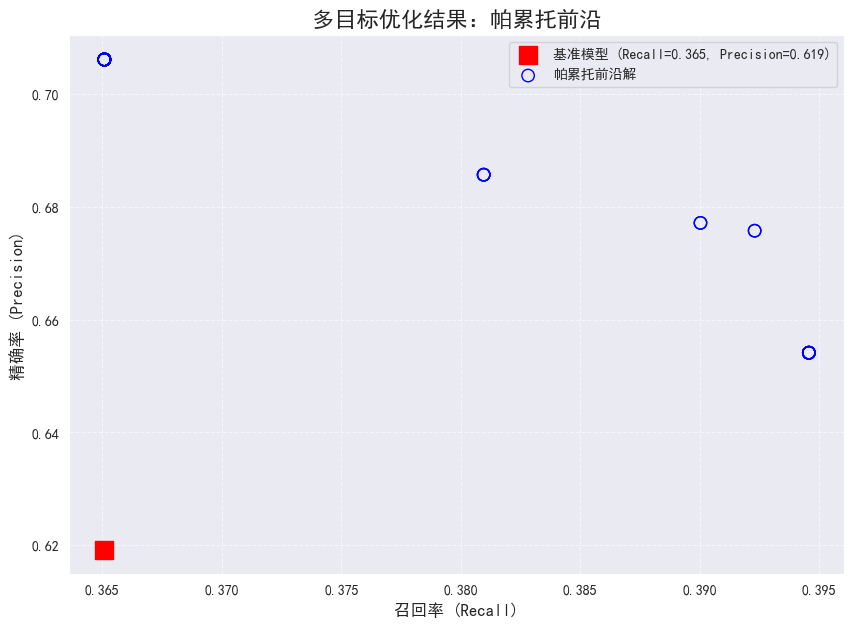

In [6]:
# 5.1 提取帕累托前沿的解

# 使用 tools.selBest 可以方便地从种群中选出最优的个体
# 在多目标优化中，它会返回所有非支配解
pareto_front = tools.selBest(final_pop, k=len(final_pop)) 

print(f"找到了 {len(pareto_front)} 个帕累托最优解。")
print("\n部分最优解 (超参数) 及其对应的 (精确率, 召回率):")
print("-" * 60)
print("n_est, max_d, min_split, min_leaf | Precision | Recall")
print("-" * 60)

# 存储结果用于绘图
pareto_points = []
for ind in pareto_front:
    params = ind
    fitness = ind.fitness.values
    pareto_points.append(fitness)
    print(f"{str(params):<30} | {fitness[0]:.5f}   | {fitness[1]:.5f}")

# 转换为numpy数组方便处理
pareto_points = np.array(pareto_points)

# 5.2 可视化帕累托前沿
plt.figure(figsize=(10, 7))

# 绘制基准模型
base_precision = precision_score(y_test, rf_pred)
base_recall = recall_score(y_test, rf_pred)
plt.scatter(base_recall, base_precision, marker='s', color='r', s=150, label=f'基准模型 (Recall={base_recall:.3f}, Precision={base_precision:.3f})', zorder=3)

# 绘制帕累托前沿
plt.scatter(pareto_points[:, 1], pareto_points[:, 0], 
            facecolors='none', edgecolors='b', s=80, label='帕累托前沿解', zorder=2)

plt.title('多目标优化结果：帕累托前沿', fontsize=16)
plt.xlabel('召回率 (Recall)', fontsize=12)
plt.ylabel('精确率 (Precision)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### 结果解读

上图中的蓝色圆圈构成了我们找到的 **帕累托前沿**。每一个点都代表了一组“最优”的超参数组合。

*   **红色方块** 是我们最开始训练的 **基准模型**。
*   可以看到，所有帕累托前沿上的解都 **支配** 了基准模型（即在召回率和精确率上都更好或至少有一项更好）。

**如何选择最终模型？**

现在，你可以根据业务需求从帕累to前沿中选择一个最合适的模型：
*   **如果业务更看重“不漏掉”**（例如，在癌症筛查中，宁可误报也不能漏掉真正的病人），你应该选择 **召回率（Recall）更高** 的点（图右侧的点）。
*   **如果业务更看重“不误报”**（例如，在垃圾邮件过滤中，宁可漏掉一些垃圾邮件也不能把正常邮件当成垃圾邮件），你应该选择 **精确率（Precision）更高** 的点（图上方的点）。
*   如果需要一个 **平衡** 的模型，可以选择位于“拐点”附近的点。

通过多目标优化，我们不再是得到一个单一的“最佳”模型，而是得到了一系列“各有所长”的优秀模型，这为实际应用提供了更大的灵活性。